In [16]:
# Objective: Getting people per admin area per landslide risk zone

# Input: admin0, admin1, region, landslide_raster (with x number of risk categories)
# Output: admin0, admin1 and region with one column per landslide_raster category containing number of people

# Steps:
# Load population data and landslide data
# Reproject so pixel size matches
# Create a mask from land slide data
# Use mask on population dataset
# Apply zonal stats across masked population dataset

In [17]:
import os
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import psycopg2 # required for exporting to postgis
import rioxarray as rxr
from rasterio.crs import CRS
from sqlalchemy import create_engine
import rasterstats
from shapely.ops import transform
from datetime import datetime
import numpy as np

from rasterio.enums import Resampling

import xarray
import matplotlib.pyplot as plt

In [18]:
os.chdir('D:\iMMAP\proj\ASDC\data\Landslide')

In [19]:
password = 'pewp7re'
db_connection_url = "postgresql://postgres:{}@localhost:5432/HSDC".format(password)
con = create_engine(db_connection_url)

In [20]:
pd.set_option('display.max_columns', None)

In [21]:
# Define projection
#repro_crs = '+proj=cea'

In [22]:
# Load adm data
adm = gpd.GeoDataFrame.from_postgis('SELECT * from afg_admbnda_adm1', con) #.to_crs(repro_crs)

### Reproject Raster

In [23]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [24]:
landslide = xarray.open_dataarray(r"afg_ls_30m_wb_s3_repro_clip_clip.tif").squeeze()
# D:\iMMAP\proj\ASDC\data\afg_ls_30m_wb_s3_compressed.tif
pop = xarray.open_dataarray(r"worldpop_clip.tif").squeeze()
# D:\iMMAP\data\Afghanistan\HSDC-Official\afg_worldpop_2020_UNadj_unconstrained.tif

In [25]:
print("Original Raster:\n----------------\n")
print_raster(landslide)
print("Raster to Match:\n----------------\n")
print_raster(pop)

Original Raster:
----------------

shape: (8124, 11755)
resolution: (0.000296968550659294, -0.00029697948621368786)
bounds: (68.189874794, 33.008563730000006, 71.680740107, 35.421225076)
sum: 144120272.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (2895, 4189)
resolution: (0.0008333333301503922, -0.0008333333302245241)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 13708900.0
CRS: EPSG:4326



In [26]:
# Reproject to match target raster
landslide_repro = landslide.rio.reproject_match(pop)

In [27]:
print("Reprojected Raster:\n-------------------\n")
print_raster(landslide_repro)
print("Raster to Match:\n----------------\n")
print_raster(pop)

Reprojected Raster:
-------------------

shape: (2895, 4189)
resolution: (0.0008333333301503925, -0.000833333330224523)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 18301380.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (2895, 4189)
resolution: (0.0008333333301503922, -0.0008333333302245241)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 13708900.0
CRS: EPSG:4326



In [28]:
# Save reprojected landslide data to file
landslide_repro.rio.to_raster("process\landslide_repro_clip.tif")

CPLE_AppDefinedError: Deleting process\landslide_repro_clip.tif failed: Permission denied

### Mask population data with land slide risk categories

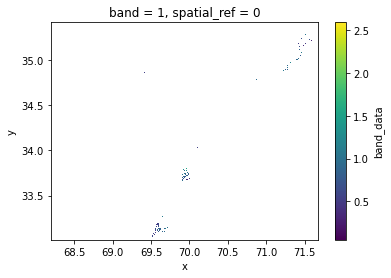

In [29]:
# Create a mask from land slide data and apply to pop
risk_category = 2
pop_masked = pop.where(landslide_repro == risk_category, other=np.nan) # Only re

pop_masked.plot()
#ignore_classes = [0, 1, 2, 3, 4, 5, 6, 7]
#pop_masked.rio.to_raster("pop_masked_test.tif")
#for risk_category in ignore_classes:
#    pop = pop.where(landslide_repro != risk_category, other=np.nan) # Only returns pixels 

In [ ]:
pop_masked_nodata = pop_masked.rio.write_nodata(0)
pop_masked_nodata.rio.to_raster('process\pop_risk_cat2.tif')

#landslide_repro.rio.write_nodata
#nodata=np.nan

In [30]:
# Loop through risk cats and create one dataset per cat

risk_category_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for risk_category in risk_category_list:
    pop_masked = pop.where(landslide_repro == risk_category, other=0)
    pop_masked.rio.to_raster('process_v02\pop_landside_risk_cat_{}.tif'.format(risk_category))


In [ ]:
# Apply zonal stats across masked population dataset

In [9]:
# Datasets
#adm
#landslide_repro
#pop_masked_path
landslide_repro_path = "process\landslide_repro_clip.tif"
pop_masked_path = "process\pop_risk_cat2_nodata.tif"

In [52]:
# Extracting population
def ZonalStats(shape_gdf, raster, stats, nodata_value):

    zonalSt = rasterstats.zonal_stats(shape_gdf, raster, stats = stats, nodata=nodata_value)
    
    df = pd.DataFrame(zonalSt)
    
    df_concat = pd.concat([df, shape_gdf], axis=1)
    
    final_gdf = gpd.GeoDataFrame(df_concat, geometry=df_concat.geom) #wkb_geometry
    
    final_gdf_ordered = final_gdf[[c for c in final_gdf if c not in [stats]] + [stats]]
    
    #flood = final_gdf_ordered.rename(columns={"sum": "pop_sum"}) #, inplace=True)
    
    flood = final_gdf_ordered.drop(columns=['geometry'])
    
    flood = flood.set_geometry('geom')
    
    return flood

In [134]:
#adm_stats = ZonalStats(adm, pop_masked_path, 'sum')

# For risk category list of raster paths: do zonal stats and save to adm_stats

adm_stats = adm
risk_category_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for category in risk_category_list:
    raster = r'process_v02\pop_landside_risk_cat_{}.tif'.format(category)
    print(raster)
    
    adm_stats = ZonalStats(adm_stats, raster, 'sum', 'NaN') #change column name
 
    adm_stats = adm_stats.rename(columns={'sum': 'pop_{}'.format(category)})
    
    col = 'pop_{}'.format(category)
    
    adm_stats[col] = adm_stats[col].round(decimals=2)

process_v02\pop_landside_risk_cat_0.tif
process_v02\pop_landside_risk_cat_1.tif
process_v02\pop_landside_risk_cat_2.tif
process_v02\pop_landside_risk_cat_3.tif
process_v02\pop_landside_risk_cat_4.tif
process_v02\pop_landside_risk_cat_5.tif
process_v02\pop_landside_risk_cat_6.tif
process_v02\pop_landside_risk_cat_7.tif
process_v02\pop_landside_risk_cat_8.tif


In [135]:
adm_stats
#adm_stats[['sum_0', 'sum_1'] ]
sum_list = [
    'pop_0',
    'pop_1',
    'pop_2',
    'pop_3',
    'pop_4',
    'pop_5',
    'pop_6',
    'pop_7',
    'pop_8'
]

adm_stats['pop_sum'] = adm_stats[sum_list].sum(axis=1)

In [140]:
#0=Null; 1-3=Low; 4-5=Moderate; 6=High; 7-9=Very High
adm_stats['pop_ls_0'] = adm_stats['pop_0']
adm_stats['pop_ls_1'] = adm_stats[['pop_1', 'pop_2', 'pop_3']].sum(axis=1)
adm_stats['pop_ls_2'] = adm_stats[['pop_4', 'pop_6']].sum(axis=1)
adm_stats['pop_ls_3'] = adm_stats['pop_6']
adm_stats['pop_ls_4'] = adm_stats[['pop_7', 'pop_8']].sum(axis=1)

In [141]:
adm_stats

,id,geom,shape_leng,shape_area,adm1_en,adm1_da,adm1_pcode,adm1_ref,adm1alt1en,adm1alt2en,adm1alt1da,adm1alt2da,adm0_en,adm0_da,adm0_pcode,date,validon,validto,reg_en,reg_da,reg_pcode,pop_0,pop_1,pop_2,pop_3,pop_4,pop_5,pop_6,pop_7,pop_8,pop_sum,pop_ls_0,pop_ls_1,pop_ls_3,pop_ls_4,pop_ls_5,pop_ls_2
0,1,"MULTIPOLYGON (((68.09305 32.39244, 68.09359 32...",10.487964,2.085632,Ghazni,غزنی,AF11,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,"MULTIPOLYGON (((62.55349 29.38911, 62.53482 29...",10.325135,3.794569,Nimroz,نیمروز,AF34,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,"MULTIPOLYGON (((71.19753 35.31710, 71.19756 35...",6.917788,0.950518,Nuristan,نورستان,AF16,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,"MULTIPOLYGON (((65.53684 32.44911, 65.53608 32...",8.156241,1.265532,Uruzgan,ارزگان,AF25,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,"MULTIPOLYGON (((69.81884 34.80029, 69.81822 34...",2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,12608.31,3.85,0.75,17087.82,53563.43,70405.11,53262.57,33618.92,6061.66,246612.42,12608.31,17092.42,53262.57,39680.58,39680.58,106826.00
5,6,"MULTIPOLYGON (((68.17123 31.83539, 68.17001 31...",8.002717,1.810899,Paktika,پکتیکا,AF12,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,7,"MULTIPOLYGON (((68.99315 36.47280, 68.99071 36...",4.801921,0.794449,Kunduz,کندز,AF19,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,North Eastern,سهیل ختیځه حوزه,NE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,8,"MULTIPOLYGON (((63.95156 29.42677, 63.94845 29...",15.864174,5.749524,Hilmand,هلمند,AF30,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,9,"MULTIPOLYGON (((65.61898 33.31015, 65.61822 33...",9.220719,1.324432,Daykundi,دایکندی,AF24,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Central Highland,لوړه مرکزی حوزه,CH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,10,"MULTIPOLYGON (((67.78405 32.14015, 67.78477 32...",8.211958,1.627631,Zabul,زابل,AF26,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Southern,جنوبی حوزه,SR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
